## Comparison of MUF Uncertainty Formats
#### Path 1. No error on file for comparison
1. Import a list of files for the Monte Carlo files
2. Calculate a mean (or median) and a standard deviation file using frequency_model_collapse
3. Change the uncertainty column names and join the table 
4. Create a standard error table with the file that you want to compare

#### Path 2. Comparison of Monte Carlo and sensitivity analysis
1. Import a list of files for the Monte Carlo files
2. Calculate a mean (or median) and a standard deviation file using frequency_model_collapse
3. Change the uncertainty column names and join the table 
4. Import a list of files for the sensitivity analysis
5. Import the nominal value file
5. Find the difference of the nominal file and sensitivity analysis
6. 


In [1]:
# import needed modules
import os
import wx
# For some reason the Code.DataHandlers.StatistiCALModels module is slow to load
from pyMeasure import *

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.Analysis.Uncertainty
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [2]:
# define constants
MUF_RESULTS_DIRECTORY=r'C:\Share\MUF_FILES\DUTs'
MONTECARLO_DIRECTORY=os.path.join(MUF_RESULTS_DIRECTORY,r"Open_SOLT_Support\MonteCarlo")
MONTECARLO_FILES=os.listdir(MONTECARLO_DIRECTORY)
nominal_file=SNP(os.path.join(MUF_RESULTS_DIRECTORY,r"Open_SOLT_Support\Open_SOLT_0.s2p"))

In [3]:
# need to put these in a single module FrontEnds/WxDialogFunctions (done 2017-02-06 by AWS)
# Define some helper functions
def get_directory():
    """Creates a directory dialog and returns the selected directory"""
    app = wx.App(None)
    dialog = wx.DirDialog(None, 'Select a MonteCarlo Directory')
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path
def get_path(wildcard='*.*'):
    """Creates a file dialog and returns the selected file"""
    app = wx.App(None)
    style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST
    dialog = wx.FileDialog(None, 'Open',wildcard=wildcard, style=style)
    if dialog.ShowModal() == wx.ID_OK:
        path = dialog.GetPath()
    else:
        path = None
    dialog.Destroy()
    return path

In [4]:
# Example Code for a single pass using the SP2V1 class to import the files
initial_file=S2PV1(os.path.join(MONTECARLO_DIRECTORY,MONTECARLO_FILES[0]))
combined_table=Snp_to_AsciiDataTable(initial_file)
for file_name in MONTECARLO_FILES[1:]:
    snp_file=S2PV1(os.path.join(MONTECARLO_DIRECTORY,file_name))
    table=Snp_to_AsciiDataTable(snp_file)
    combined_table+table
mean_table=frequency_model_collapse_multiple_measurements(combined_table)
standard_deviation=frequency_model_collapse_multiple_measurements(combined_table,
                                                                  method='std')
new_column_names=['Frequency']+['u'+name for name in standard_deviation.column_names[1:]]
standard_deviation.column_names=new_column_names
reference_curve=ascii_data_table_join("Frequency",mean_table,standard_deviation)

In [5]:
# More general example that uses the SNP classs to import the files
initial_file_snp=SNP(os.path.join(MONTECARLO_DIRECTORY,MONTECARLO_FILES[0]))
combined_table_snp=Snp_to_AsciiDataTable(initial_file)
for file_name in MONTECARLO_FILES[1:]:
    snp_file=SNP(os.path.join(MONTECARLO_DIRECTORY,file_name))
    table=Snp_to_AsciiDataTable(snp_file)
    #print(str(table).splitlines()[0:2])
    # This is not acting how I would expect
    combined_table_snp+table
    #print(str(str(combined_table_snp).splitlines()[0:2])+" length {0}".format(len(combined_table_snp.data)))
mean_table_snp=frequency_model_collapse_multiple_measurements(combined_table_snp)
standard_deviation_snp=frequency_model_collapse_multiple_measurements(combined_table_snp,
                                                                  method='std')
new_column_names=['Frequency']+['u'+name for name in standard_deviation_snp.column_names[1:]]
standard_deviation_snp.column_names=new_column_names
reference_curve_snp=ascii_data_table_join("Frequency",mean_table_snp,standard_deviation_snp)

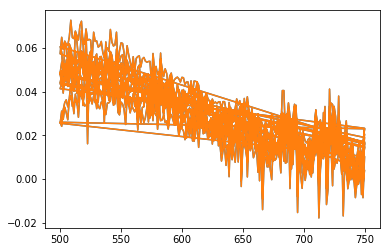

In [6]:
# just a plot to make sure the frequency range is the same, used to debug table addition problem with converted SNP files
plt.plot(combined_table_snp["Frequency"],combined_table_snp["reS11"])
plt.plot(combined_table["Frequency"],combined_table["reS11"])
plt.show()

In [7]:
# Create a standard error file that compares the montecarlo based reference curve with the nominal solution
standard_error=standard_error_data_table(reference_curve_snp,nominal_file,
                                         value_column_names=mean_table.column_names[1:],
                                        table_1_uncertainty_column_names=new_column_names[1:],
                                        expansion_factor=1)

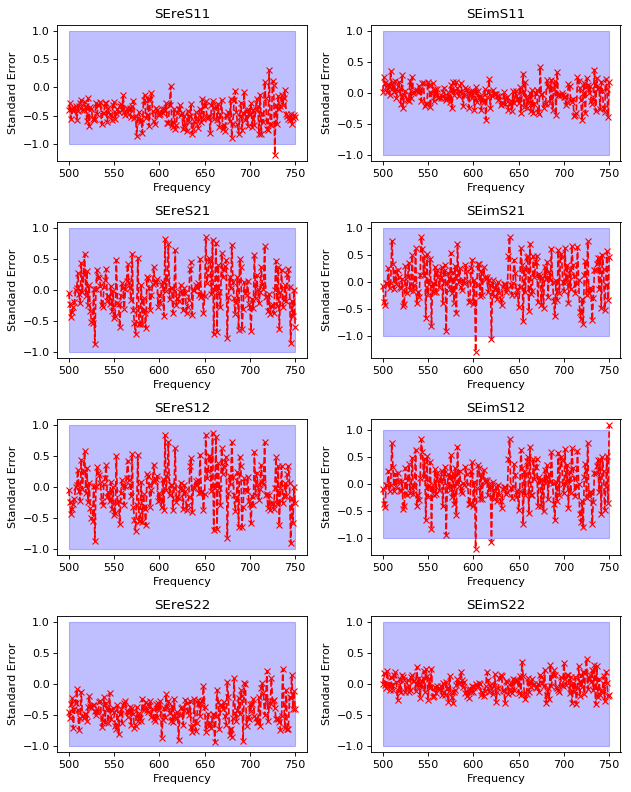

In [8]:
# plot the standard error file
standard_error.show();

In [9]:
# This function also lives in Code.DataHandlers.Translations
def Snp_to_AsciiDataTable(snp_model):
    """Converts snp files to AsciiDataTable"""
    options=snp_model.options
    options['data']=snp_model.data
    options['column_names']=snp_model.column_names
    options['column_types']=['float' for i in snp_model.column_names]
    options["extension"]="txt"
    new_table=AsciiDataTable(None,**options)
    return new_table

In [53]:
def create_monte_carlo_reference_curve(monte_carlo_directory,**options):
    """Creates a standard curve from a montecarlo directory (from MUF). The standard curve
    has a mean or median and a standard deviation for the uncertainty"""
    defaults={"method":"mean","format":"RI","filter":"s\d+p"}
    reference_options={}
    for key,value in defaults.iteritems():
        reference_options[key]=value
    for key,value in options.iteritems():
        reference_options[key]=value
    file_names=os.listdir(monte_carlo_directory)
    filtered_file_names=[]
    for file_name in file_names[:]:
        if re.search(reference_options["filter"],file_name,re.IGNORECASE):
            filtered_file_names.append(file_name)
    file_names=filtered_file_names
    #print file_names
    initial_file=SNP(os.path.join(monte_carlo_directory,file_names[0]))
    initial_file.change_data_format(reference_options["format"])
    combined_table=Snp_to_AsciiDataTable(initial_file)
    
    for file_name in file_names[1:]:
        snp_file=SNP(os.path.join(monte_carlo_directory,file_name))
        snp_file.change_data_format(reference_options["format"])
        table=Snp_to_AsciiDataTable(snp_file)
        combined_table+table
    mean_table=frequency_model_collapse_multiple_measurements(combined_table,method=reference_options["method"])
    standard_deviation=frequency_model_collapse_multiple_measurements(combined_table,
                                                                      method='std')
    new_column_names=['Frequency']+['u'+name for name in standard_deviation.column_names[1:]]
    standard_deviation.column_names=new_column_names
    reference_curve=ascii_data_table_join("Frequency",mean_table,standard_deviation)
    reference_curve.options["value_column_names"]=mean_table.column_names[1:]
    reference_curve.options["uncertainty_column_names"]=new_column_names[1:]
    return reference_curve


    
    

In [11]:
def frequency_model_difference(model_1, model_2, **options):
    """Takes the difference of two models that both have frequency and a similar set of columns. Returns an object that is
    a list of [[frequency,column_1,..column_n],...] where columns are the same in the models. If  a particular subset of
    columns is desired use columns=["Frequency","magS11] models can be any subclass of AsciiDataTable, SNP, or
    pandas.DataFrame, if a column is a non-numeric type it drops it. The frequency list should be unique
    (no multiple frequencies) for at least one model"""
    # Set up defaults and pass options
    defaults = {"columns": "all", "interpolate": False, "average": True}
    difference_options = {}
    for key, value in defaults.iteritems():
        difference_options[key] = value
    for key, value in options.iteritems():
        difference_options[key] = value

    # first check type, if it is a panadas data frame a little conversion is needed, else is for all other models
    if type(model_1) in [pandas.DataFrame]:
        model_1 = DataFrame_to_AsciiDataTable(model_1)
    if type(model_2) in [pandas.DataFrame]:
        model_2 = DataFrame_to_AsciiDataTable(model_2)
    # now start with a set of frequencies (unique values from both)
    frequency_set_1 = set(model_1["Frequency"])
    frequency_set_2 = set(model_2["Frequency"])
    model_2_frequency_selector = model_2.column_names.index('Frequency')
    column_names_set_1 = set(model_1.column_names)
    column_names_set_2 = set(model_2.column_names)

    # All points must be in the intersection to be used
    frequency_intersection = list(frequency_set_1.intersection(frequency_set_2))
    column_names_intersection = list(column_names_set_1.intersection(column_names_set_2))

    if not frequency_intersection:
        print("The models do not have any frequency points in common")
        return None
    new_column_names = ["Frequency"]
    column_types=['float']
    for column_index, column in enumerate(model_1.column_names):
        if column in column_names_intersection and column not in ["Frequency"]:
            new_column_names.append(column)
            column_types.append(model_1.options["column_types"][column_index])

    difference_data = []
    for row_index, frequency in enumerate(model_1["Frequency"]):
        new_row = [frequency]
        if frequency in frequency_intersection:
            model_2_frequency_row = filter(lambda x: x[model_2_frequency_selector] == frequency, model_2.data)[0]
            # print("{0} is {1}".format("model_2_frequency_row",model_2_frequency_row))
            for column_index, column in enumerate(model_1.column_names):
                if column in column_names_intersection and column not in ["Frequency"]:
                    model_2_column_selector = model_2.column_names.index(column)
                    if re.search('int|float',
                                 model_1.options["column_types"][column_index],
                                 re.IGNORECASE) and re.search('int|float',
                                                              model_2.options["column_types"][model_2_column_selector],
                                                              re.IGNORECASE):

                        new_row.append(
                            model_1.data[row_index][column_index] - model_2_frequency_row[model_2_column_selector])

                        # Print("New Column Names are {0}".format(new_column_names))
                    elif difference_options["columns"] in ["all"]:
                        new_row.append(model_1.data[row_index][column_index])
            difference_data.append(new_row)
    difference_options["column_names"] = new_column_names
    # print("New Column Names are {0}".format(new_column_names))
    difference_options["data"] = difference_data
    difference_options["column_types"]=column_types
    print column_types
    result = AsciiDataTable(None, **difference_options)
    return result

In [38]:
def create_sensitivity_reference_curve(sensitivity_directory,nominal_file_path="../DUT_0.s2p",**options):
    """Creates a standard curve from a sensitivity_directory usually called Covariance(from MUF). The standard curve
    has a mean or median and a RMS variance from the nominal value for the uncertainty"""
    defaults = {"format": "RI", "filter": "s\d+p"}
    reference_options = {}
    for key, value in defaults.iteritems():
        reference_options[key] = value
    for key, value in options.iteritems():
        reference_options[key] = value
    file_names = os.listdir(sensitivity_directory)
    filtered_file_names = []
    for file_name in file_names[:]:
        if re.search(reference_options["filter"], file_name, re.IGNORECASE):
            filtered_file_names.append(file_name)
    file_names = filtered_file_names
    # print file_names
    nominal_file=SNP(os.path.join(sensitivity_directory, nominal_file_path))
    nominal_file.change_data_format(reference_options["format"])
    initial_file = SNP(os.path.join(sensitivity_directory, file_names[0]))
    initial_file.change_data_format(reference_options["format"])
    initial_difference=frequency_model_difference(nominal_file,initial_file)
    #print initial_difference.column_names
    combined_table = initial_difference
    for file_name in file_names[1:]:
        snp_file = SNP(os.path.join(sensitivity_directory, file_name))
        snp_file.change_data_format(reference_options["format"])
        difference=frequency_model_difference(nominal_file,snp_file)
        #print difference.column_names
#         table = Snp_to_AsciiDataTable(difference)
        combined_table + difference
    #print combined_table.options["column_types"]
    variance = frequency_model_collapse_multiple_measurements(combined_table,
                                                                        method='rms')
    new_column_names = ['Frequency'] + ['u' + name for name in variance.column_names[1:]]
    mean_table=Snp_to_AsciiDataTable(nominal_file)
    variance.column_names = new_column_names
    reference_curve = ascii_data_table_join("Frequency", mean_table, variance)
    reference_curve.options["value_column_names"] = mean_table.column_names[1:]
    reference_curve.options["uncertainty_column_names"] = new_column_names[1:]
    return reference_curve

In [39]:
def plot_reference_curve(reference_curve,**options):
    """Plots a frequency based reference curve by using the options 
    value_column_names and uncertainty_column_names."""
    defaults={"display_legend":False,
                  "save_plot":False,
                  "directory":os.getcwd(),
                  "specific_descriptor":"Reference_Curve",
                  "general_descriptor":"Plot",
                  "file_name":None,
                  "plots_per_column":2,
                  "plot_format":'b-',
                  "fill_color":'k',
                  "fill_opacity":.25,
                  "fill_edge_color":'k',
                  "plot_size":(8, 10),
                  "dpi":80,
                  "independent_axis_column_name":"Frequency",
                  "plot_size":(8,6),
                  "dpi":80,
                  "share_x":"col"}
    plot_options={}
    
    for key,value in defaults.iteritems():
        plot_options[key]=value
    for key,value in options.iteritems():
        plot_options[key]=value
        
    value_columns=reference_curve.options["value_column_names"]
    uncertainty_columns=reference_curve.options["uncertainty_column_names"]
    number_plots=len(value_columns)
    number_columns=int(plot_options["plots_per_column"])
    number_rows=int(round(float(number_plots)/float(number_columns)))
    fig,reference_axes=plt.subplots(nrows=number_rows, ncols=number_columns, 
                                    sharex=plot_options["share_x"], 
                                    figsize=plot_options["plot_size"], 
                                    dpi=plot_options["dpi"])
    x_data=reference_curve[plot_options["independent_axis_column_name"]]
    for axes_index,ax in enumerate(reference_axes.flat):
        y_data=np.array(reference_curve[value_columns[axes_index]])
        error=np.array(reference_curve[uncertainty_columns[axes_index]])
        ax.plot(x_data,y_data,plot_options["plot_format"])
        ax.fill_between(x_data,y_data-error,y_data+error,
                       color=plot_options["fill_color"],
                       alpha=plot_options["fill_opacity"],
                       edgecolor=plot_options["fill_edge_color"])
        ax.set_title(value_columns[axes_index])
        
    
    plt.tight_layout()
    # Dealing with the save option
    if plot_options["file_name"] is None:
        file_name=auto_name(specific_descriptor=plot_options["specific_descriptor"],
                            general_descriptor=plot_options["general_descriptor"],
                            directory=plot_options["directory"],extension='png',padding=3)
    else:
        file_name=plot_options["file_name"]
    if plot_options["save_plot"]:
        #print file_name
        plt.savefig(os.path.join(plot_options["directory"],file_name))
    else:
        plt.show()
    return fig



    

<IPython.core.display.Javascript object>


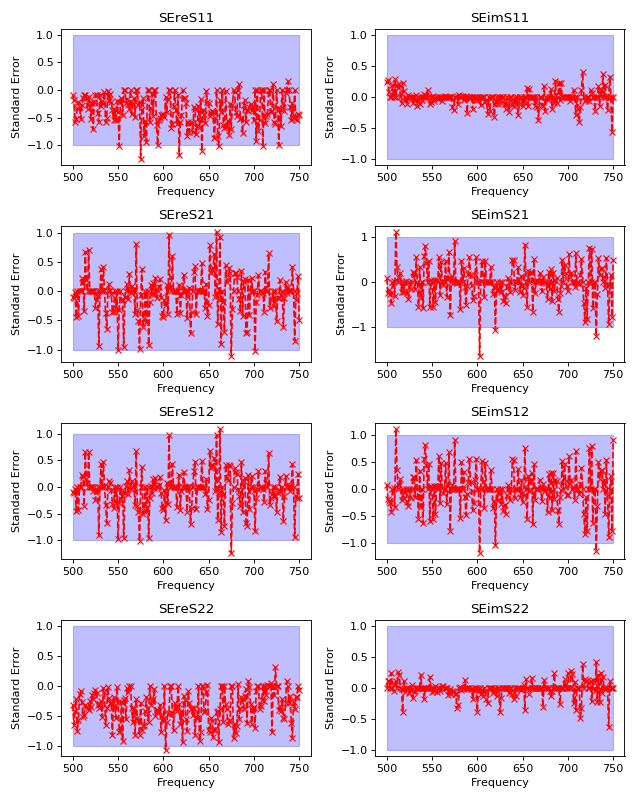

In [74]:
%matplotlib notebook
data_format="RI"
montecarlo_directoy=get_directory()
reference_curve=create_monte_carlo_reference_curve(montecarlo_directoy,format=data_format,method="median")
comparison_path=get_path("*.s*p")
comparison_snp=SNP(comparison_path)
comparison_snp.change_data_format(data_format)
comparison_table=Snp_to_AsciiDataTable(comparison_snp)
standard_error=standard_error_data_table(reference_curve,comparison_table,
                                         value_column_names=reference_curve.options["value_column_names"],
                                        table_1_uncertainty_column_names=reference_curve.options["uncertainty_column_names"],
                                        expansion_factor=1)
fig=standard_error.show(plots_per_column=2);

<IPython.core.display.Javascript object>


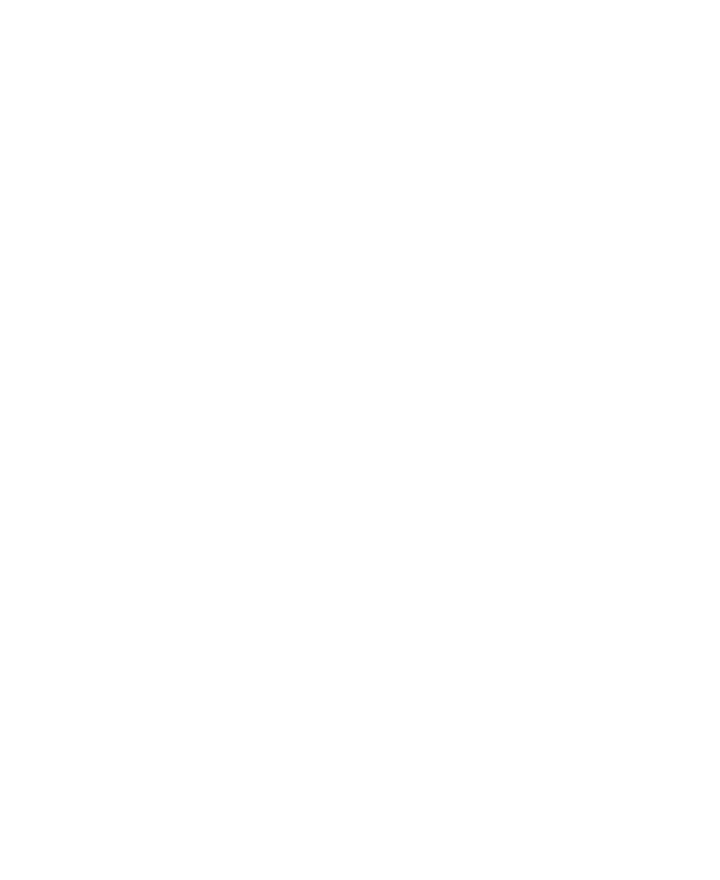

In [14]:
fig=plot_reference_curve(reference_curve,save_plot=False,specific_descriptor="Reference_Curve_100Points_Median",
                        plot_size=(9,11))
fig.suptitle("MA Open Montecarlo Reference Curve")
#plt.tight_layout()
plt.savefig("MA_Open_SOLT_DUT_10pts.png")

In [15]:
# save the file with a larger size
fig.set_size_inches(18.5, 30)
fig.savefig("test.png")


<IPython.core.display.Javascript object>


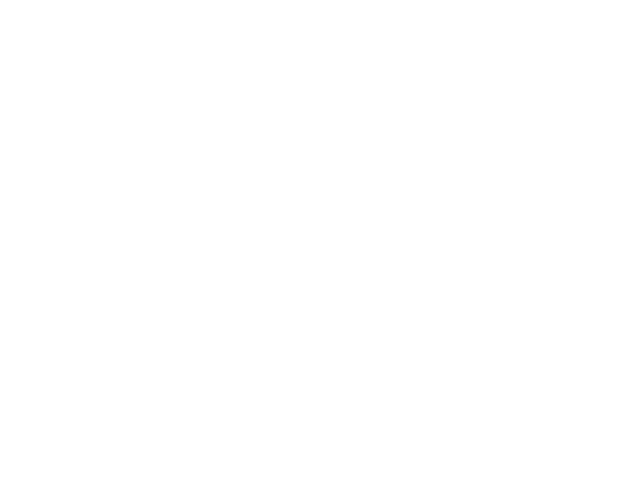

NameError: name 'comparsion_snp' is not defined

In [16]:
fig=plot_reference_curve(reference_curve,save_plot=True,specific_descriptor="Reference_Curve_100Points_Median")
fig.hold()
plt.plot(comparsion_snp["Frequency"])

In [47]:
def frequency_model_collapse_multiple_measurements(model,**options):
    """Returns a model with a single set of frequencies. Default is to average values together
    but geometric mean, std, variance and median are options. Geometric means of odd number of negative values fails"""
    defaults={"method":"mean"}
    # load other options from model
    for option,value in model.options.iteritems():
        if not re.search('begin_line|end_line',option):
            defaults[option]=value
    for element in model.elements:
        if model.__dict__[element]:
            if re.search("meta",element,re.IGNORECASE):
                defaults["metadata"]=model.metadata.copy()
            else:
                defaults[element]=model.__dict__[element][:]


    collapse_options={}
    for key,value in defaults.iteritems():
        collapse_options[key]=value
    for key,value in options.iteritems():
        collapse_options[key]=value    
    unique_frequency_list=sorted(list(set(model["Frequency"])))
    frequency_selector=model.column_names.index("Frequency")
    out_data=[]
    for index, frequency in enumerate(unique_frequency_list):
        data_row=filter(lambda x: x[frequency_selector]==frequency,model.data[:])
        if re.search('mean|av',collapse_options["method"],re.IGNORECASE):
            new_row=np.mean(np.array(data_row),axis=0).tolist()
        elif re.search('median',collapse_options["method"],re.IGNORECASE):
            new_row=np.median(np.array(data_row),axis=0).tolist()
        elif re.search('geometric',collapse_options["method"],re.IGNORECASE):
            new_row=gmean(np.array(data_row),axis=0).tolist()
        elif re.search('st',collapse_options["method"],re.IGNORECASE):
            new_row=np.std(np.array(data_row),axis=0).tolist()
        elif re.search('var',collapse_options["method"],re.IGNORECASE):
            new_row=np.var(np.array(data_row),axis=0,dtype=np.float64).tolist()
        elif re.search('rms',collapse_options["method"],re.IGNORECASE):
            new_row=np.sqrt(np.mean(np.square(np.array(data_row)),axis=0,dtype=np.float64)).tolist()
        out_data.append(new_row)

    collapse_options["data"]=out_data

    if collapse_options["specific_descriptor"]:
        collapse_options["specific_descriptor"]=collapse_options["method"]+"_"+\
        collapse_options["specific_descriptor"]
        
    
    resulting_model=AsciiDataTable(None,**collapse_options)
    return resulting_model

['float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float']
['float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float']
['float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float']
['float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float']


<IPython.core.display.Javascript object>


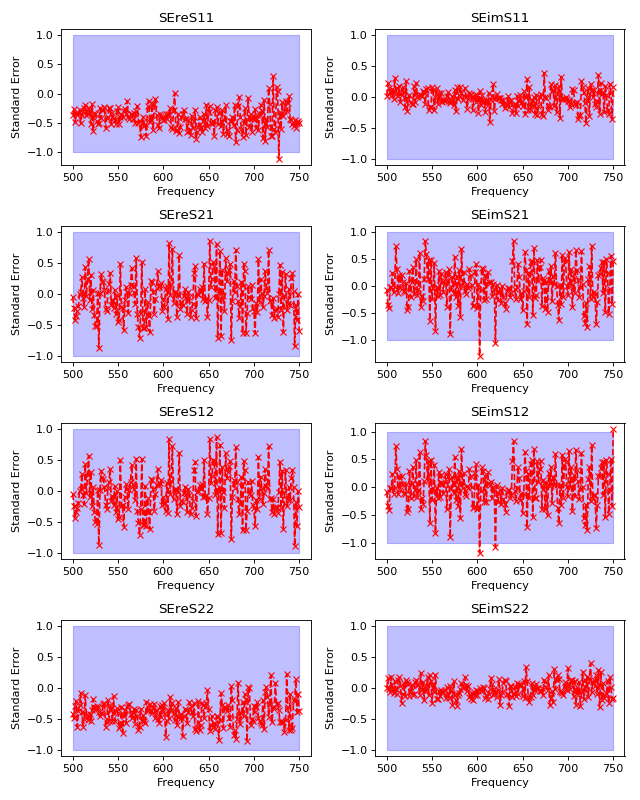

In [128]:
%matplotlib notebook
data_format="RI"
montecarlo_directoy=get_directory()
monte_carlo_reference_curve=create_monte_carlo_reference_curve(montecarlo_directoy,format=data_format,method="mean")
sensitivity_directory=get_directory()
nominal_path=get_path("*.s*p")
sensitivity_reference_curve=create_sensitivity_reference_curve(sensitivity_directory,
                                                               nominal_file_path=nominal_path,
                                                              format=data_format)

standard_error=standard_error_data_table(monte_carlo_reference_curve,sensitivity_reference_curve,
                                         value_column_names=monte_carlo_reference_curve.options["value_column_names"],
                                        table_1_uncertainty_column_names=monte_carlo_reference_curve.options["uncertainty_column_names"],
                                        table_2_uncertainty_column_names=sensitivity_reference_curve.options["uncertainty_column_names"],
                                        expansion_factor=1,
                                        table_2_uncertainty_type="table")
fig=standard_error.show(plots_per_column=2);

<IPython.core.display.Javascript object>


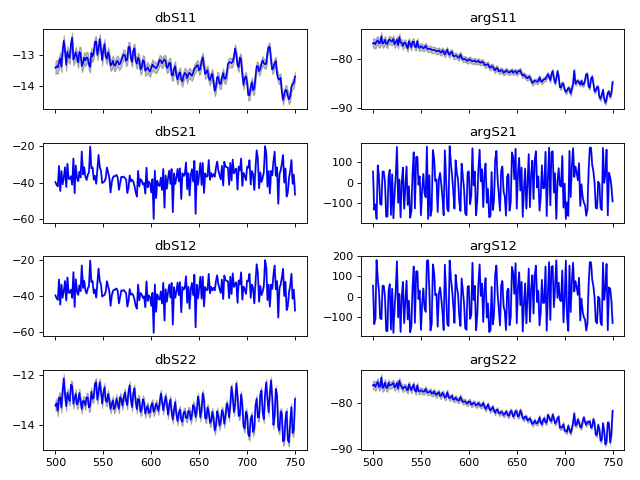

In [110]:
fig1=plot_reference_curve(sensitivity_reference_curve);

<IPython.core.display.Javascript object>


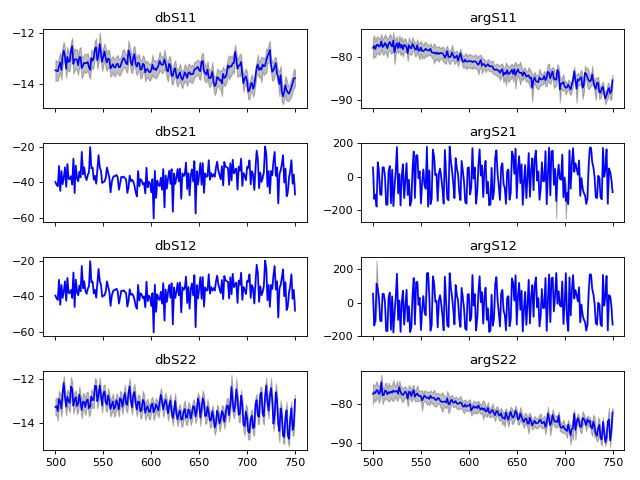

In [111]:
fig2=plot_reference_curve(monte_carlo_reference_curve);

<IPython.core.display.Javascript object>


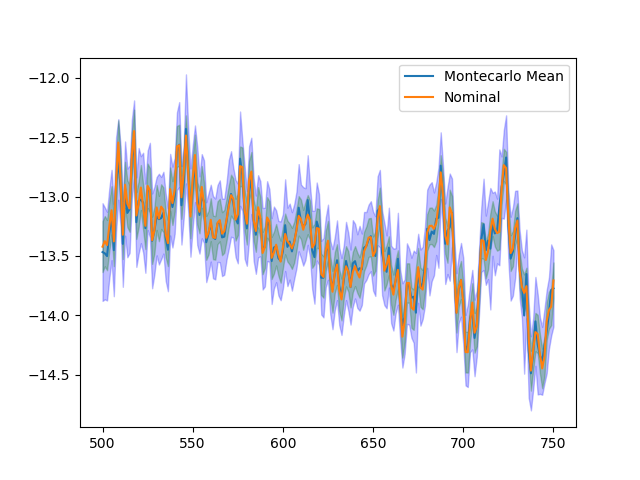

In [112]:
plt.figure()
PARAMETER="dbS11"
y_MC=np.array(monte_carlo_reference_curve[PARAMETER])
y_S=np.array(sensitivity_reference_curve[PARAMETER])
error_MC=np.array(monte_carlo_reference_curve["u"+PARAMETER])
error_S=np.array(sensitivity_reference_curve["u"+PARAMETER])
plt.plot(monte_carlo_reference_curve["Frequency"],monte_carlo_reference_curve[PARAMETER],label="Montecarlo Mean")
plt.plot(sensitivity_reference_curve["Frequency"],sensitivity_reference_curve[PARAMETER],label="Nominal")
plt.fill_between(monte_carlo_reference_curve["Frequency"],y_MC-error_MC,y_MC+error_MC,color="b",
                       alpha=.25,
                       edgecolor="k")
plt.fill_between(sensitivity_reference_curve["Frequency"],y_S-error_S,y_S+error_S,color="g",
                       alpha=.25,
                       edgecolor="k")
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


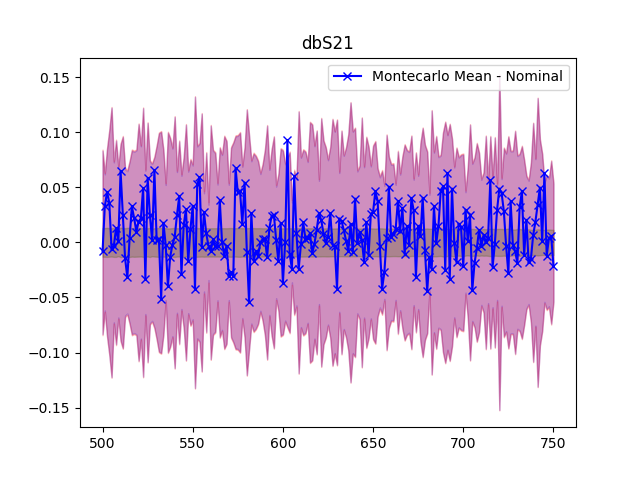

In [113]:
plt.figure()
PARAMETER="dbS21"
y_MC=np.array(monte_carlo_reference_curve[PARAMETER])
y_S=np.array(sensitivity_reference_curve[PARAMETER])
error_MC=np.array(monte_carlo_reference_curve["u"+PARAMETER])
error_S=np.array(sensitivity_reference_curve["u"+PARAMETER])
plt.plot(monte_carlo_reference_curve["Frequency"],y_MC-y_S,"b-x",label="Montecarlo Mean - Nominal")

plt.fill_between(monte_carlo_reference_curve["Frequency"],-error_MC,+error_MC,color="b",
                       alpha=.25,
                       edgecolor="k")
plt.fill_between(sensitivity_reference_curve["Frequency"],-error_S,+error_S,color="g",
                       alpha=.25,
                       edgecolor="k")
plt.fill_between(sensitivity_reference_curve["Frequency"],-np.sqrt(error_MC**2+error_S**2),
                 +np.sqrt(error_MC**2+error_S**2),color="r",
                       alpha=.25,
                       edgecolor="k")
plt.title(PARAMETER)

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


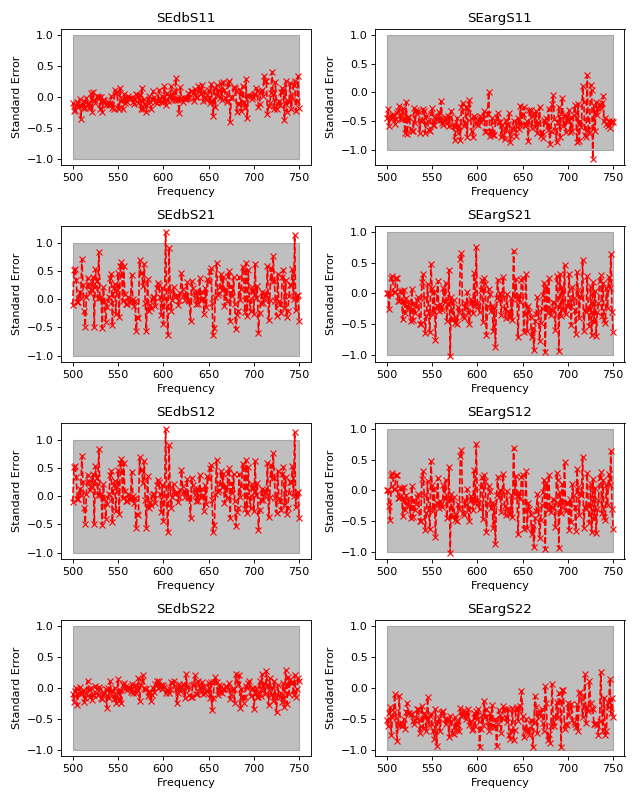

In [114]:
standard_error.show(fill_color="k",plot_format="r--x");

In [115]:
standard_error.get_conformation_dictionary().values().count(True)/len(standard_error.column_names)

0

In [116]:
int(round(float(3)/float(6)))

1

In [117]:
standard_error.get_conformation_dictionary()

{'Frequency': True,
 'SEargS11': False,
 'SEargS12': False,
 'SEargS21': False,
 'SEargS22': True,
 'SEdbS11': True,
 'SEdbS12': False,
 'SEdbS21': False,
 'SEdbS22': True}

In [118]:
standard_error_df=AsciiDataTable_to_DataFrame(standard_error)

In [127]:
len(standard_error_df[abs(standard_error_df["SEdbS21"])>1])

2